# Module 4. Homework: Evaluation

In [136]:
import numpy as np
import pandas as pd

In [137]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Data preparation

In [138]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [139]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [140]:
y_col = 'converted'
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = [x for x in df.select_dtypes(exclude='object').columns.tolist() if x not in y_col]

y_col, categorical, numerical

('converted',
 ['lead_source', 'industry', 'employment_status', 'location'],
 ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'])

In [141]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0)

In [142]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

### Data split

In [143]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

ys = []
for d in [df_full_train, df_train, df_val, df_test]:
    d.reset_index(drop=True, inplace=True)
    y = d[y_col].values
    ys.append(y)
    del d[y_col]

y_full_train, y_train, y_val, y_test = ys
del ys

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [144]:
from sklearn.metrics import roc_auc_score

scores = []
for col in numerical:
    score = roc_auc_score(y_train, df_train[col].values)
    scores.append(score)


feature_importance = pd.DataFrame.from_dict({'columns' : numerical, 'score' : scores})
feature_importance.sort_values('score', ascending=False)

,columns,score
0,number_of_courses_viewed,0.763568
2,interaction_count,0.738270
3,lead_score,0.614499
1,annual_income,0.551958


## Question 2: Model AUC

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [145]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import  LogisticRegression

In [146]:
def get_dicts(df):
    return df[categorical + numerical].to_dict(orient='records')

In [147]:
dicts_train = get_dicts(df_train)
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dicts_train)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [148]:
dicts_pred = get_dicts(df_val)
X = dv.transform(dicts_pred)
y_pred = model.predict_proba(X)[:, 1]

score = roc_auc_score(y_val, y_pred)
selection = np.array([0.32, 0.52, 0.72, 0.92])

auc_evaluation = pd.DataFrame.from_dict({'values':selection, 'difference':np.abs(selection - score)})
auc_evaluation.sort_values('difference', ascending=True)

,values,difference
2,0.72,0.097132
3,0.92,0.102868
1,0.52,0.297132
0,0.32,0.497132


## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [149]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

/home/semyon/mlzoomcamp-homework/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/semyon/mlzoomcamp-homework/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


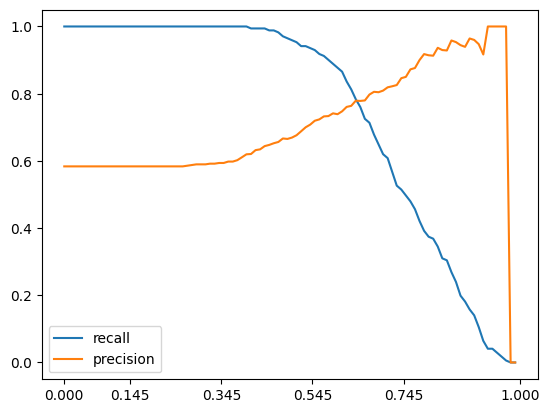

In [150]:
thresholds = np.arange(0.0, 1, 0.01)

recall_scores = []
precision_scores = []
for t in thresholds:
    y_pred_threshold = y_pred >= t
    recall_scores.append(recall_score(y_val, y_pred_threshold))
    precision_scores.append(precision_score(y_val, y_pred_threshold))

plt.xticks([0, 0.145, 0.345, 0.545, 0.745, 1])
plt.plot(thresholds, recall_scores, label='recall')
plt.plot(thresholds, precision_scores, label='precision')
plt.legend()

In [151]:
df_scores = pd.DataFrame.from_dict({'thresholds': thresholds, 'recall' : recall_scores, 'precision': precision_scores})
#Threshold intersection
df_scores[abs(df_scores['precision'] - df_scores['recall']) < 0.01]

,thresholds,recall,precision
64,0.64,0.783626,0.77907
98,0.98,0.000000,0.00000
99,0.99,0.000000,0.00000


In [152]:
threshold_precision_recall_intersection = pd.DataFrame.from_dict({'selection' : [0, 0.145, 0.345, 0.545, 0.745, 1]})
threshold_precision_recall_intersection['diff'] = np.abs(threshold_precision_recall_intersection.selection.values - 0.64)
threshold_precision_recall_intersection.sort_values('diff')

,selection,diff
3,0.545,0.095
4,0.745,0.105
2,0.345,0.295
5,1.000,0.360
1,0.145,0.495
0,0.000,0.640


## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [153]:
df_scores['f1'] = 2 * ( df_scores['precision'] * df_scores['recall'] / (df_scores['precision'] + df_scores['recall']) )

df_scores[df_scores['thresholds'].isin([0.14, 0.34, 0.54, 0.74])].sort_values('f1', ascending=False).head()

,thresholds,recall,precision,f1
54,0.54,0.935673,0.707965,0.806045
34,0.34,1.000000,0.593750,0.745098
14,0.14,1.000000,0.583618,0.737069
74,0.74,0.514620,0.846154,0.640000


## Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [154]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [155]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=5):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    dicts = get_dicts(df_train)
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    dicts = get_dicts(df_val)
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

deviation = np.std(scores)
scores_evaluation = pd.DataFrame.from_dict({'answers': [0.0001, 0.006, 0.06, 0.36]})
scores_evaluation['diff'] = np.abs(scores_evaluation.answers - deviation)
scores_evaluation.sort_values('diff', ascending=True).head()

  0%|          | 0/5 [00:00<?, ?it/s]

,answers,diff
2,0.0600,0.024193
1,0.0060,0.029807
0,0.0001,0.035707
3,0.3600,0.324193


## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [156]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = []
for c in tqdm([0.000001, 0.001, 1]):
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        dicts = get_dicts(df_train)
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(dicts)

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)

        dicts = get_dicts(df_val)
        X = dv.transform(dicts)
        y_pred = model.predict_proba(X)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    results.append({'C': c, 'mean': np.mean(scores), 'std': np.std(scores)})

df_results = pd.DataFrame(results)
df_results.sort_values('mean', ascending=False)

  0%|          | 0/3 [00:00<?, ?it/s]

,C,mean,std
1,0.001000,0.866878,0.028746
2,1.000000,0.822109,0.035807
0,0.000001,0.560208,0.023798
